In [1]:
import os
import boto3
import pandas as pd
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker.predictor import RealTimePredictor
from sagemaker.predictor import csv_serializer

from ipywidgets import interact_manual, SelectionSlider
from IPython.display import display

import custom_rnn_util as util

# Time Series Analysis

Forecasting time series, that contains information on sequential events, can be carried out by fitting the data to a probability distribution. This enables us to formulate past and future trends as the results of a parametric equation.

In the ideal scenario, if we know the probability function for quantities we aim to forecast, for a given initial value, we could find values of all future states. However, in reality, such as when predicting a stock value, we do not all factors influencing the stock, and therefore cannot formaulate a probability function that governs relationship between all these factors.

Therefore, we use a numeric approximation by discretizing time into small intervals and computing the evolution of values based on available information, such as trends within the past evolution of states, and some other boundary conditions, such as news media articles, strike price of an option, etc.

![Discretization of a dynamic system into finite states and formulation of future trends as a function of past trends](../images/financial-time-series.gif)

Deep learning approaches used in predicting such trends in stock prices uses trends in multiple correlated variables, such as price trends of similar stocks, market sentiment etc., without any assumption on their probability distribution. Deep learning techniques leverage short and long term memory of micro/macro cycles observed in the past by training the model to learn what matters and what doesn't.

In the original **Recurrent Neural Network (RNN)** design, a delay unit is used, which memorizes the state at a given time step and re-injects it into the deep layers at the next time step, recurrently over a chosen period of time (called lags). The algorithm learns to infer a sequence of future values (called horizon) based on a given lag by learning over multiple pairs of lag-horizon taken across the available timeline. This is referred to as sequence to sequence learning.

![Architecture of recurrent neural networks and gated recurrent units (GRU)](../images/financial-time-series-rnn-gru.gif)

The recurrence equation can make the network very deep because it replicates the entire hidden network at every step and leads to vanishing memory (i.e. the influence of the deepest layers vanishes due to repeated multiplications of small number derivatives needed to reach these layers during the process of gradient optimization). More advanced gated systems such as **Gated Recurrent Units (GRU)** help with the vanishing memory issue, by re-injecting prior time-step learning into more recent time-step learning to benefit from both long term and short term memory.

In this workshop, you'll create a dynamic network based on Gated Recurrent Units for target and covariates. As target, you'll use closing price of a chosen stock, with some other metrices such as opening price, and maximum and minimum prices of the same stock, as well as few other stocks, whose movement show some similarity (based on the clustering analysis you did in the previous module).

As described in the readme section of the workshop repository, you'll use code written in separate [training](../container/rnn/train) and [prediction](../container/rnn/predictor.py) files.

# Stock Price Prediction of a single stock, using custom RNN based model

The training and prediciton algorithm used for this exercise is pre-written for you, using TensorFlow with Keras binding, and is available under the container folder of the repository you cloned through notebook configuration. The code to be used for [training](../container/rnn/train) and [prediction](../container/rnn/predictor.py) is already available, and within the scope of this exercise, you'll simply package the available code within a container image, and use SageMaker's high level Estimator API for training the model and hosting the trained model behind an HTTP endpoint.

The following diagram provides an overview of the container architecture, to be used in this scenario.
![BYOA Container Architecture](../images/byoa-container-architecture.png)

The container model used here, is derived from the [blog post](https://aws.amazon.com/blogs/machine-learning/train-and-host-scikit-learn-models-in-amazon-sagemaker-by-building-a-scikit-docker-container/) describing how to train and host Sciki-Learn models on SageMaker. With the only difference being yuou'll be using Keras with TensorFlow, instead of Scikit-Learn, the container architecture remains the same.

This also serves to demonstrate that SageMaker capabilities can be extend to virtually any algorithm you use, using any popular Machine Leanrning libraries, with ease.

## Hyperparameters

The training code is written, so that it is customizable via several hyperparamaters. These are passed to the `Estimator` simply as a JSON variable. You can investigate the training code and see that the code is written to assume default values for all parameters, if not specified. 

Following is an overview of few, that you can change if you like, before executing training job:

- interval : Use only values `D`(for day) or `H`(for hours). During data preparation we had raw data resampled at various interval levels and saved in S3 buckets. This parameter would tell you which to use. Using smaller interval, such as minute will cause the training to take much longer, whereas with larger interval, number of observed samples will be too low to extract any meaningful patterns.
- lag, horizon : These specifies how far back the model reaches out while generating prediction, and how far forward it can forecast.
- target_stock : You can use any stock symbol out of the ones that are available in traingin data file.
- covariate_stocks : This allows you to provide a list of stocks, preferably use some stocks that you found clustered within the same group during the clustering analysis you did in previous module.
- target_column : You can choose any metrics available within training data, by default, the algorithm works to use `EndPrice` as target variable
- covariate_columns : Optionally you can specify some additional series that have correlation with the main time series, such as opening price, and maximum and minimum price during past intervals. 

**In a real worls stock prediction example, you'd ideally want to use covariates based on some broader metrices, such as news analysis, options market related to underlying securities and so on.** Keep in mind though analyzing what supporting metrices to use to increase model accuracy is out of scope of this workshop. As such, the model you'll train here would have limited value in actually predicting the stock values in real world.

In [2]:
#Define parameters
interval = 'D' #Use D or H

assert interval == 'D' or interval == 'H'

if interval == 'D':
    lag = 10 # Use 10 for D, 80 for H
    horizon = 5 #Use 5 for D, 40 for H
    dateformat = '%Y-%m-%d'
elif interval == 'H':
    lag = 80 # Use 10 for D, 80 for H
    horizon = 40 #Use 5 for D, 40 for H    
    dateformat = '%Y-%m-%d %H:%M:%S'
    
target_stock = "BMW"
covariate_stocks = "CON, DAI, PAH3, VOW3"
target_column = "EndPrice"
covariate_columns = "StartPrice, MinPrice, MaxPrice"
num_epochs = 1000
percent_train = 85.0
num_units = 256
batch_size = 4096
dropout_ratio = 0.1

hyperparameters = {
    "interval": interval,
    "lag": str(lag),
    "horizon": str(horizon),
    "num_epochs": str(num_epochs),
    "batch_size": str(batch_size),
    "percent_train": str(percent_train),
    "num_units": str(num_units),
    "target_stock": target_stock,
    "covariate_stocks": covariate_stocks,
    "target_column": target_column,
    "covariate_columns": covariate_columns,
    "dropout_ratio": str(dropout_ratio)
    
}

## Training Data

During data preparation steps, you uploaded the resampled data to your S3 bucket, attached to your SageMaker session, under an appropriate prefix, depending on resampling interval. Here you refer to the data in the corresponding location, based on the interval you choose now, before submitting the training job.

In [ ]:

#Define training data location

artifactname = 'dbg-custom-rnn'
base_job_name = "{}-{}-{}".format(artifactname, interval, target_stock)

role = sagemaker.get_execution_role()
session = sagemaker.Session()
s3_bucket = session.default_bucket()
s3_data_key = 'dbg-stockdata/source'
data_location = "s3://{}/{}/{}/resampled_stockdata.csv".format(s3_bucket, s3_data_key, interval)
output_location = "s3://{}/{}/{}/output".format(s3_bucket, artifactname, interval)
s3 = boto3.client('s3')

## ECR Repository

With the code ready at hand, proceed to create a repository on Amazon ECR.

We provide an utility [script](../container/build_and_push.sh) that:
- Identifies the AWS region you are using
- Creates a repository with if it doesn't exist already
- Run Docker locally to create the container image
- Retrieves ECR Login command using the credential you are using with SageMaker
- Pushes the image, as latest, to the ECR repository

In [ ]:
# Define model artifact name and image
account = session.boto_session.client('sts').get_caller_identity()['Account']
region = session.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, artifactname)
os.chdir("../container")
!sh build_and_push.sh $artifactname

Once the repository is created, you can check your [ECR Console](https://console.aws.amazon.com/ecs/home#/repositories) to verify that the repository named `dbg-custom-rnn` have been created.

## Model Training

To train a model in [Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html), you create a training job. In this workshop, you'll do so using SageMaker's high level [Estimator API](https://sagemaker.readthedocs.io/en/latest/estimators.html).

Estimator is a generic interface that allows you to train using any supplied algorithm, which in this case is the algorithm you just packaged and pulished to your Amazon ECR repository.

Following are the necessary inputs while submitting a training job:
- Uniquely identifiable job name
- Amazon ECR registry path where the training code is stored
- URL of the Amazon S3 bucket where you have the training data stored
- URL of the S3 bucket where you want to store the output of the job (upon training completion SageMaker archives whatever files your code stores under the path `/opt/ml/modl` within the container, and makes those available as a tar-file named `model.tar.gz` at the specified location on S3

In [5]:
%%time
# Instantiate estimator with container image of artifact and backend EC2 instance(s)
rnn = Estimator(image,
                role, 1, 'ml.c5.18xlarge',
                output_path=output_location,
                base_job_name = base_job_name,
                sagemaker_session=session)

rnn.set_hyperparameters(**hyperparameters)
# Train the model
rnn.fit(data_location)
estimator_job = rnn.latest_training_job.job_name
model_archive = "{}/{}/output/{}/output/model.tar.gz".format(artifactname,interval,estimator_job)
print("Estimator created at completion of training job {}".format(estimator_job))

INFO:sagemaker:Creating training-job with name: dbg-custom-rnn-D-BMW-2018-11-06-00-33-20-882


2018-11-06 00:33:21 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training...
2018-11-06 00:35:11 Downloading - Downloading input data
2018-11-06 00:35:17 Training - Downloading the training image...
Training image download completed. Training in progress.
Using TensorFlow backend.
Starting the training.
Hyperparameters file : {"num_epochs": "1000", "num_units": "256", "lag": "10", "horizon": "5", "covariate_stocks": "CON, DAI, PAH3, VOW3", "target_stock": "BMW", "dropout_ratio": "0.1", "percent_train": "85.0", "covariate_columns": "StartPrice, MinPrice, MaxPrice", "target_column": "EndPrice", "interval": "D", "batch_size": "4096"}
Hyperparameters initialized
Loading data from : /opt/ml/input/data/training/resampled_stockdata.csv
Loading data from : /opt/ml/input/data/training/resampled_stockdata.csv
Training data loaded
100 Stock symbols found.
Records for 324 trading days found.
0-CON#0111-DAI#0112-PAH3#0113-VOW3
Rescaling 

263/263 [==============================] - 0s 153us/step - loss: 0.6357 - main_out_loss: 0.6638 - combo_out_loss: 0.5235
Epoch 57/1000

263/263 [==============================] - 0s 161us/step - loss: 0.6342 - main_out_loss: 0.6613 - combo_out_loss: 0.5256
Epoch 58/1000

263/263 [==============================] - 0s 161us/step - loss: 0.6286 - main_out_loss: 0.6567 - combo_out_loss: 0.5159
Epoch 59/1000

263/263 [==============================] - 0s 158us/step - loss: 0.6307 - main_out_loss: 0.6601 - combo_out_loss: 0.5131
Epoch 60/1000

263/263 [==============================] - 0s 156us/step - loss: 0.6252 - main_out_loss: 0.6554 - combo_out_loss: 0.5046
Epoch 61/1000

263/263 [==============================] - 0s 156us/step - loss: 0.6251 - main_out_loss: 0.6548 - combo_out_loss: 0.5061
Epoch 62/1000

263/263 [==============================] - 0s 158us/step - loss: 0.6272 - main_out_loss: 0.6568 - combo_out_loss: 0.5089
Epoch 63/1000

263/263 [==============================] - 0s 15

263/263 [==============================] - 0s 162us/step - loss: 0.2027 - main_out_loss: 0.2106 - combo_out_loss: 0.1708
Epoch 298/1000

263/263 [==============================] - 0s 153us/step - loss: 0.2078 - main_out_loss: 0.2164 - combo_out_loss: 0.1734
Epoch 299/1000

263/263 [==============================] - 0s 152us/step - loss: 0.1986 - main_out_loss: 0.2064 - combo_out_loss: 0.1674
Epoch 300/1000

263/263 [==============================] - 0s 156us/step - loss: 0.2115 - main_out_loss: 0.2211 - combo_out_loss: 0.1728
Epoch 301/1000

263/263 [==============================] - 0s 154us/step - loss: 0.2048 - main_out_loss: 0.2144 - combo_out_loss: 0.1663
Epoch 302/1000

263/263 [==============================] - 0s 161us/step - loss: 0.2083 - main_out_loss: 0.2188 - combo_out_loss: 0.1663
Epoch 303/1000

263/263 [==============================] - 0s 161us/step - loss: 0.2048 - main_out_loss: 0.2138 - combo_out_loss: 0.1690
Epoch 304/1000

263/263 [==============================] 

263/263 [==============================] - 0s 153us/step - loss: 0.1109 - main_out_loss: 0.1049 - combo_out_loss: 0.1349
Epoch 540/1000

263/263 [==============================] - 0s 152us/step - loss: 0.1067 - main_out_loss: 0.1001 - combo_out_loss: 0.1332
Epoch 541/1000

263/263 [==============================] - 0s 153us/step - loss: 0.1152 - main_out_loss: 0.1095 - combo_out_loss: 0.1378
Epoch 542/1000

263/263 [==============================] - 0s 165us/step - loss: 0.0990 - main_out_loss: 0.0908 - combo_out_loss: 0.1320
Epoch 543/1000

263/263 [==============================] - 0s 163us/step - loss: 0.1086 - main_out_loss: 0.1028 - combo_out_loss: 0.1316
Epoch 544/1000

263/263 [==============================] - 0s 157us/step - loss: 0.1003 - main_out_loss: 0.0924 - combo_out_loss: 0.1318
Epoch 545/1000

263/263 [==============================] - 0s 158us/step - loss: 0.1120 - main_out_loss: 0.1062 - combo_out_loss: 0.1354
Epoch 546/1000

263/263 [==============================] 

263/263 [==============================] - 0s 163us/step - loss: 0.0814 - main_out_loss: 0.0711 - combo_out_loss: 0.1227
Epoch 780/1000

263/263 [==============================] - 0s 165us/step - loss: 0.0761 - main_out_loss: 0.0649 - combo_out_loss: 0.1210
Epoch 781/1000

263/263 [==============================] - 0s 155us/step - loss: 0.0860 - main_out_loss: 0.0771 - combo_out_loss: 0.1216
Epoch 782/1000

263/263 [==============================] - 0s 154us/step - loss: 0.0796 - main_out_loss: 0.0697 - combo_out_loss: 0.1193
Epoch 783/1000

263/263 [==============================] - 0s 157us/step - loss: 0.0819 - main_out_loss: 0.0721 - combo_out_loss: 0.1209
Epoch 784/1000

263/263 [==============================] - 0s 152us/step - loss: 0.0829 - main_out_loss: 0.0728 - combo_out_loss: 0.1232
Epoch 785/1000

263/263 [==============================] - 0s 156us/step - loss: 0.0913 - main_out_loss: 0.0833 - combo_out_loss: 0.1231
Epoch 786/1000

263/263 [==============================] 


2018-11-06 00:36:34 Uploading - Uploading generated training model
2018-11-06 00:36:39 Completed - Training job completed
Billable seconds: 89
Estimator created at completion of training job dbg-custom-rnn-D-BMW-2018-11-06-00-33-20-882
CPU times: user 728 ms, sys: 60 ms, total: 788 ms
Wall time: 3min 42s


You can observe in the [training](../container/rnn/train) code, that loss obtained after each epoch is stored alongwith the trained model, in the output location.

Following utility function, as implemented in [custom_rnn_util](./custom_rnn_util.py) Python file, extracts the loss history file and plots the loss. You should verify that loss is progressively lower, as trainign progresses, ths validating that gradient descent converges over the epochs and the loss is minimized.

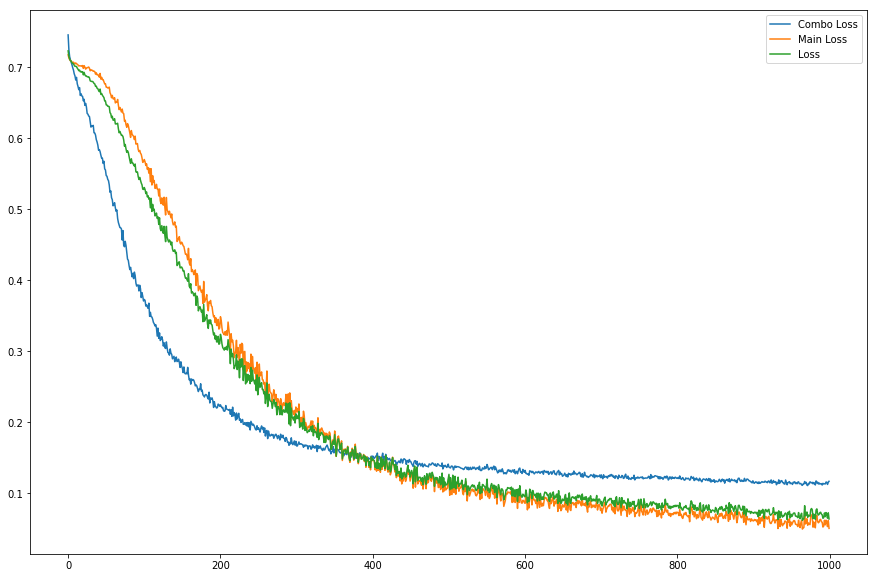

In [6]:
util.plot_loss(s3, s3_bucket, model_archive, "loss_history.csv")

## Model Deployment

Deploying a model using Amazon SageMaker hosting services is a three-step process:
- Creating a model : tell SageMaker where it can find model components
- Creating configuration for an HTTPS endpoint: specify name of one or more model variants and the number and size of compute instances to use in serving prediction requests
- Creating an HTTPS endpoint: launch required ML compute instances and deploy the model onto those instances

While you can execute all of these steps from within your AWS Console, using the high level `Estimator` API, provides a quick way to execute all pf these steps at once.

In [7]:
%%time
# Create an endpoint on a web server
predictor = rnn.deploy(1, 'ml.m4.xlarge', serializer=csv_serializer)

INFO:sagemaker:Creating model with name: dbg-custom-rnn-2018-11-06-00-37-03-988
INFO:sagemaker:Creating endpoint with name dbg-custom-rnn-D-BMW-2018-11-06-00-33-20-882


---------------------------------------------------------------!CPU times: user 308 ms, sys: 16 ms, total: 324 ms
Wall time: 5min 19s


While the model is being deployed, you can verify that Model and Endpoint  configuration is created, and that the Endpoint is being provisioned, from [SageMaker console](https://console.aws.amazon.com/sagemaker/home#/endpoints).

Once the deployment is complete, the status of the endpoint would change to `In Service`, at which point you are ready to use the endpoint to generate predictions.

## Forecasting and Plotting

Upon completion of deployment, your predictor will have an handle to the endpoint you just provisioned. 

If using this notebook at any later time, or with a previously deployed endpoint, you can simply obtain a handle to the the endpoint, by specifying the right estimator job name, and instantiating a `RealTimePredictor` with the job name and content type.

In [ ]:
#estimator_job = 'dbg-custom-rnn-D-BMW-2018-11-06-00-33-20-882'
#estimator_job = 'dbg-custom-rnn-H-BMW-2018-11-04-09-55-28-663'
predictor = RealTimePredictor(estimator_job, content_type = "text/csv")
model_archive = "{}/{}/output/{}/output/model.tar.gz".format(artifactname,interval,estimator_job)

Within the training code, we split the test data into few samples of size spanning the combined lag and horizon interval, and stored the CSV files for the whole test set, as well as the split test set, in model output location. These files are therefore available within the model archive.

First you use utility methods, as implemented in [custom_rnn_util](./custom_rnn_util.py) Python file to extract and load these files. The functions also saves uncompressed CSV files in the output location on S3, alongside the model archive.

In [8]:
filepaths = util.extract_matching_csv_files_from_s3_tarfile(s3, s3_bucket, model_archive, "test[0-9]+.csv", model_archive[:model_archive.find("/model")], 0)

testfilename = "testdata.csv"
testdata = util.load_csv_from_s3_tarfile(s3, s3_bucket, model_archive, testfilename, model_archive[:model_archive.find("/model")], 0)

If you follow the prediction code at [predictor.py](../container/rnn/predictor.py), you'll notice that the `transform`  method, that gets invoked when a request is sent, is written to handle either an S3 location containing the CSV file for the data to be used for forecasting, or serialized CSV data directly.

While sending serialized CSV as request payload is convenient, for very large size models requiring data spanning long interval, might increase the latency and network traffic. As opposed to that, if you have your data already stored in S3, ability to just specify the data lcoation on S3 helps in containing network traffic and this faster turnaround.

As a first test, you invoke prediction by simply passing the extracted S3 location of test sample files to the predictor. The utility function also plots the forecasted data, alongside the observed data.


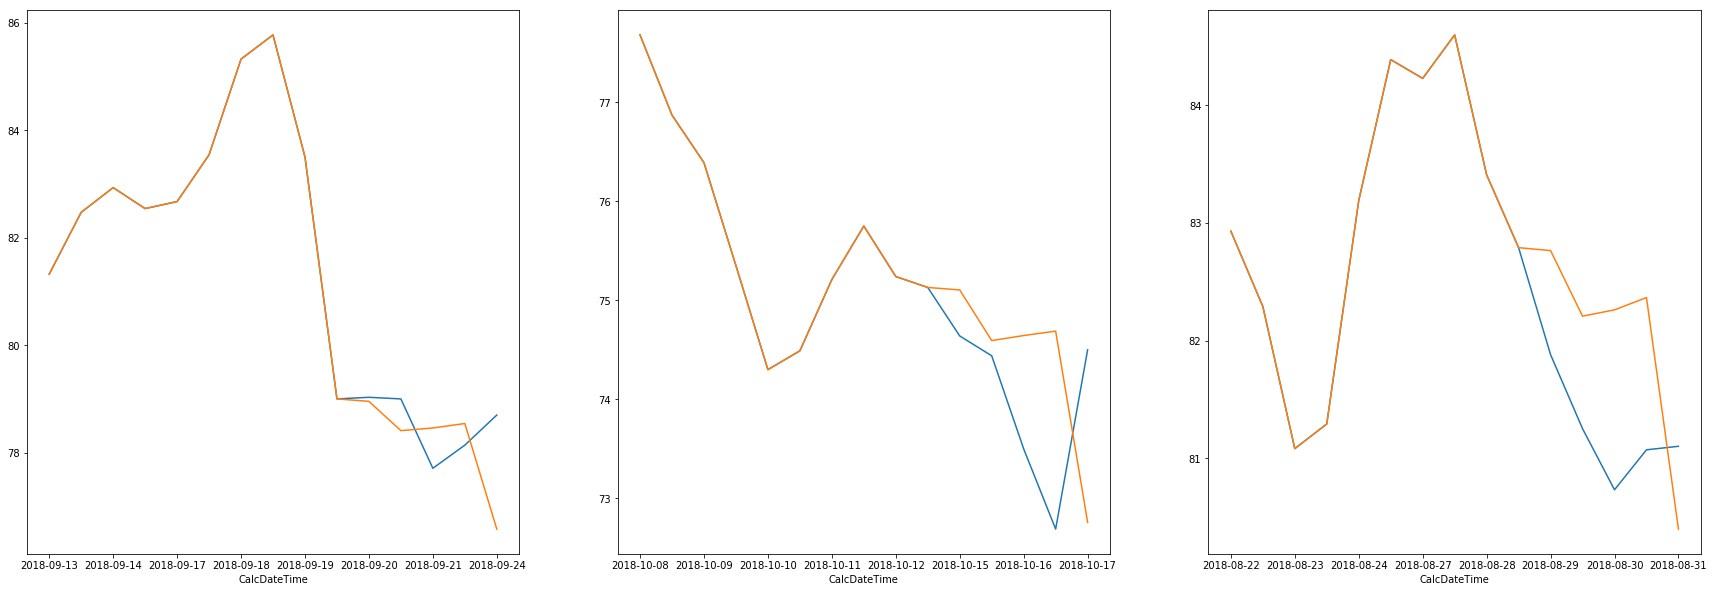

In [9]:
util.plot_sample_predictions(predictor, filepaths, target_stock, target_column, lag)

As a second test, to verify the ability to generate predictions by passing serialized CSV data, you use the following utility function, with a specified increment, that generates a series of predictions at the incremental level specified, and plots similar graphs.

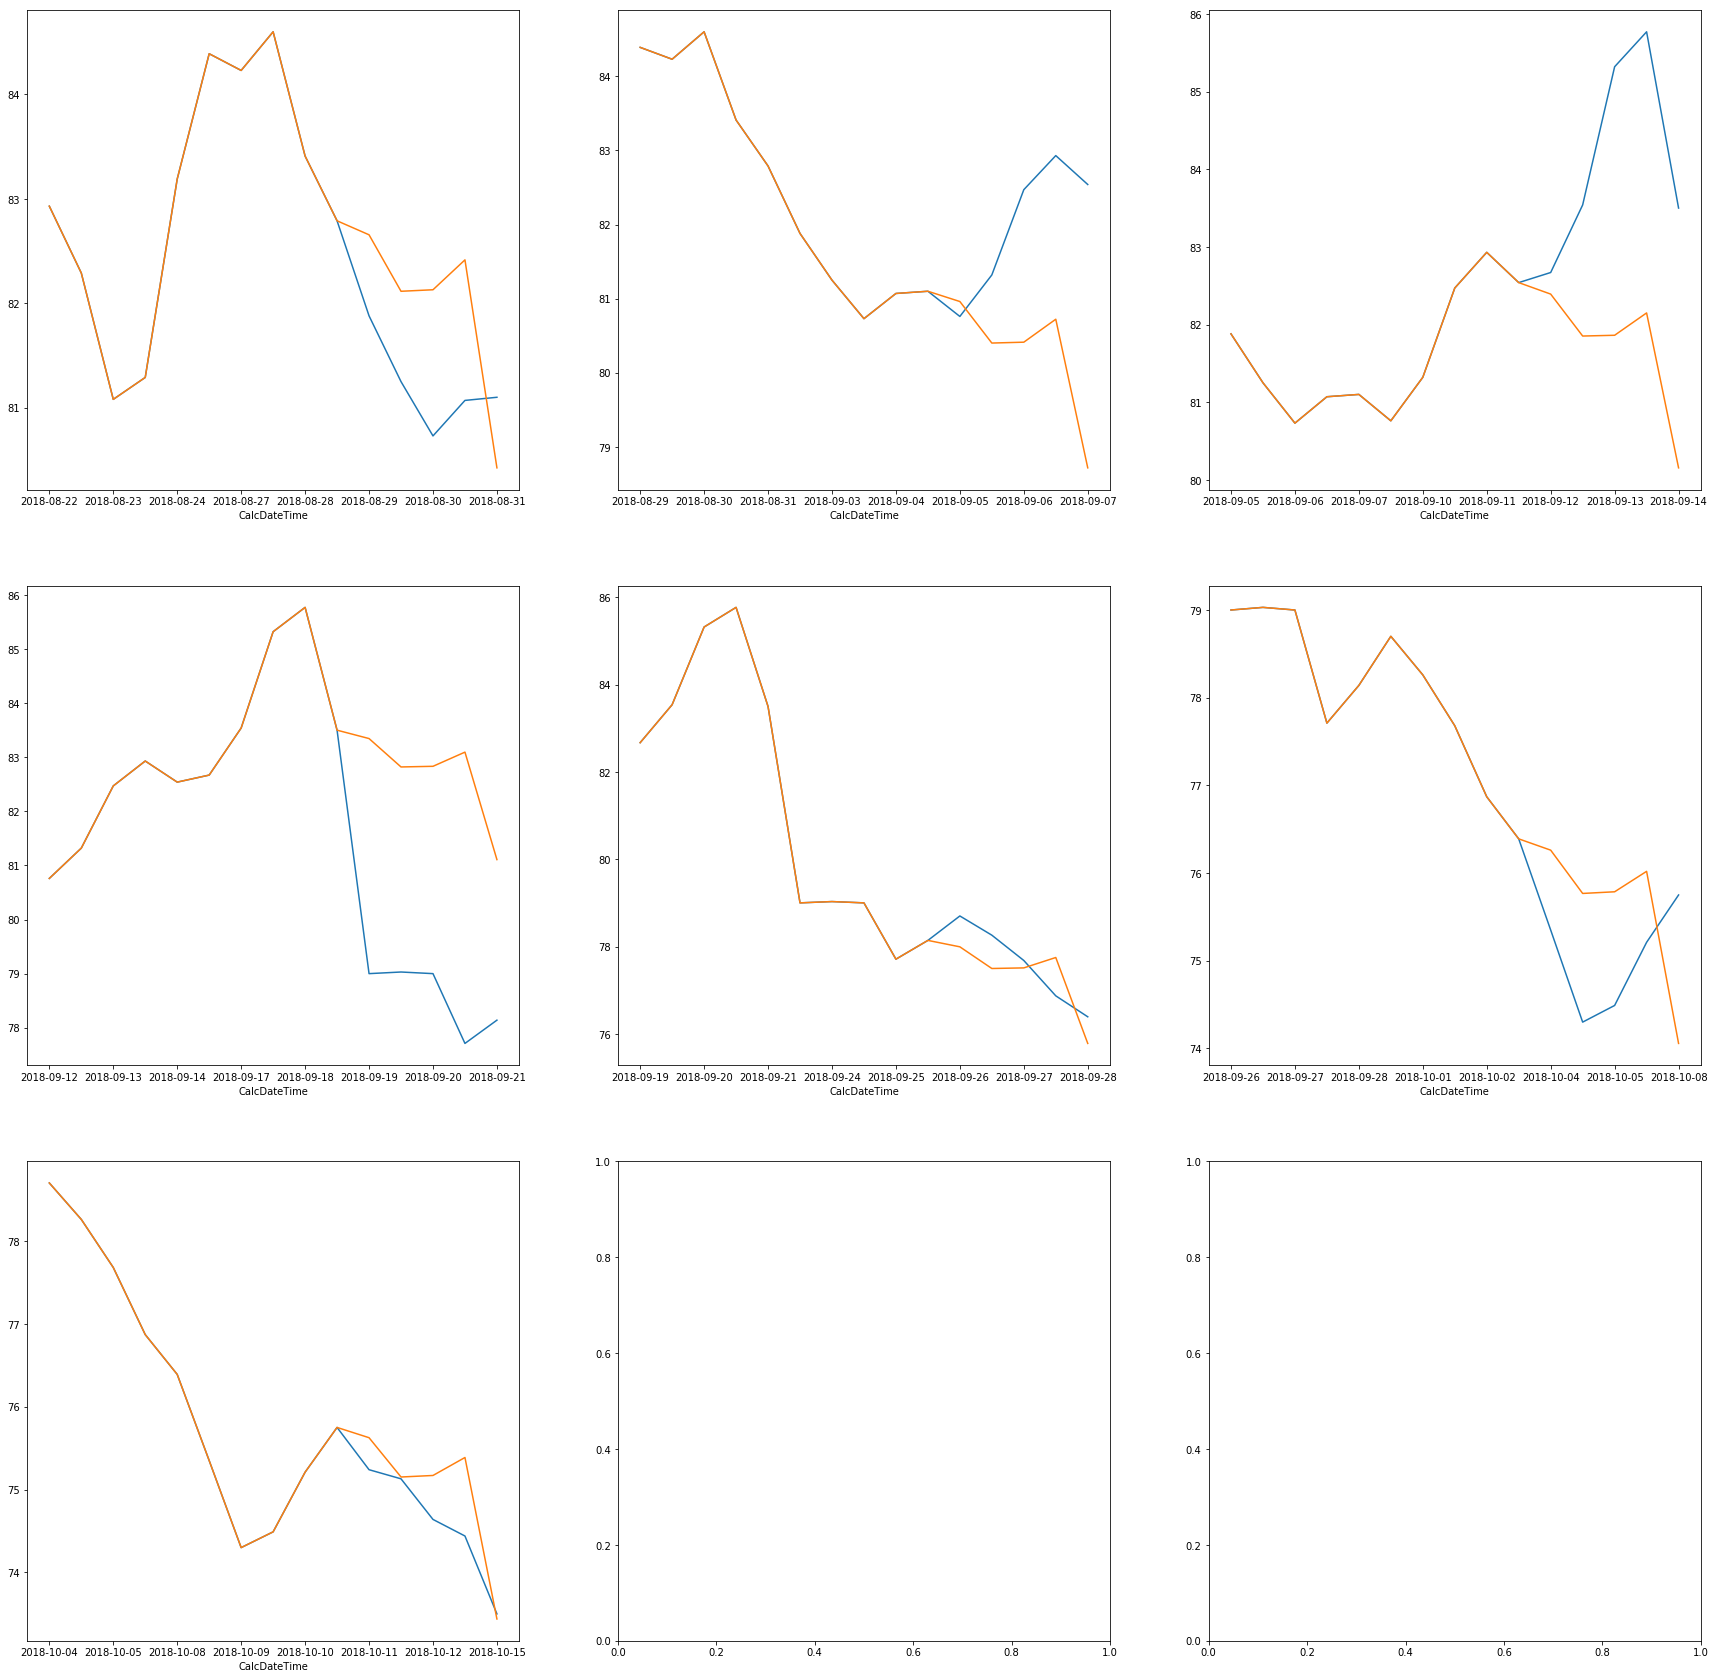

In [10]:
util.plot_sample_test_performance(predictor, testdata, target_stock, covariate_stocks, target_column, lag, horizon, horizon)

As you can observe in the above plots, the predictor does a good job in predicting on certain dates, not so good on others.

You can also use another utility function, as follows, to plot the forecasts slightly differently, superimposing all the predicitons upon an end to end plot of test data.

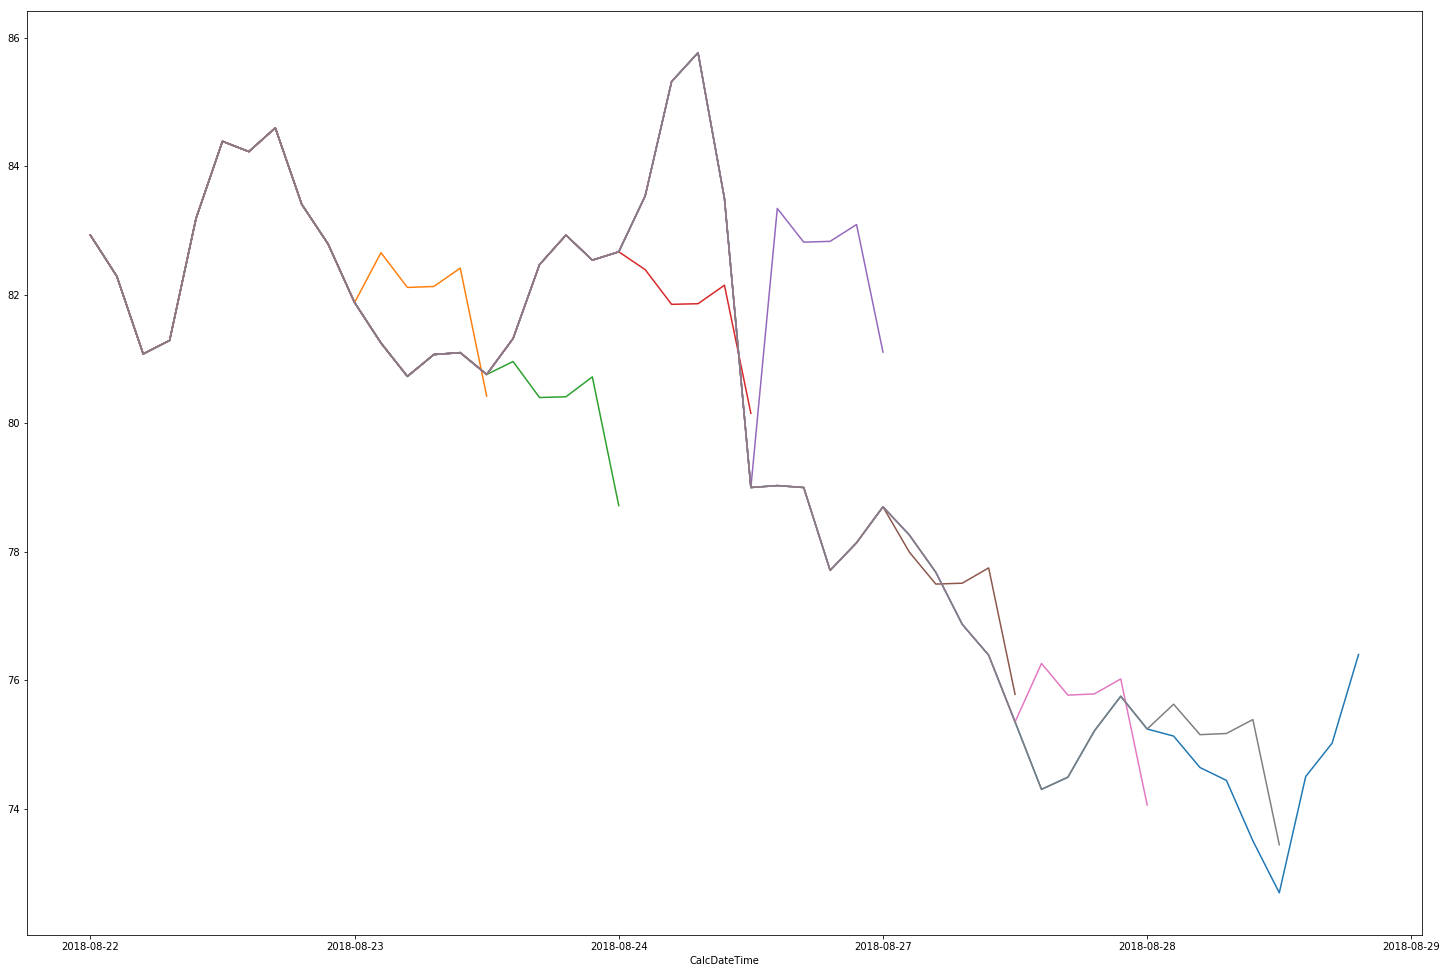

In [11]:
util.plot_overall_test_performance(predictor, testdata, target_stock, covariate_stocks, target_column, lag, horizon, horizon)

If you chose to use data sampled at daily intervals, you should see that the forecasts closely followed the observed values in slightly more than 50% of cases. This indicates that our rudimentary model does a better job than at least a random guess, in predicting stock price movements.

Lastly, feel free to play around with the interactive widget, to generate forecast on any chosen date, simply by choosing the forecast date using a slider. You might see that for some dates/times there is no data, and that's becasue there are non-trading days/hours within the training/test set.

When you move on to the the next module, you'll see how you can use an AWS provided algorithm, that is equipped to deal with such gaps in data.

In [12]:
dateoptions = util.get_date_range(testdata, target_stock, dateformat, lag, horizon, interval)
style = {'description_width': 'initial'}
@interact_manual(
    forecast_date = SelectionSlider(options=dateoptions,style=style)    
)
def plot_interact(forecast_date):
    try:
        forecast_date_index = list(testdata.index).index(forecast_date.strftime(dateformat))
        print("Generating forecast for {} onwards".format(forecast_date.strftime(dateformat)))        
        util.predict_and_plot(predictor, testdata, forecast_date_index, target_stock, covariate_stocks, target_column, lag, horizon)         
    except ValueError:
        print("Data for {} doesn't exist".format(forecast_date.strftime(dateformat)))
  

interactive(children=(SelectionSlider(description='forecast_date', options=(('2018-09-04', Timestamp('2018-09-…

## Some Final Thoughts

1. In our custom RNN based code, we used a particular stock's price as main time series, and optionally used some others as exogenous time series. As you might have noticed, for example if you trained your model using `BMW` as main series, and `Chrysler`, `Volkswagon`, `Contiental` and `Porsche` as covariates, you cannot use the same model to generate predictions for any of those other stocks. In order to forecast using this approach, you'll have to train one model each for every stock you want to forecast.

1. Our choice of using opening and maximum and minimum price may not be a good choice in actually forecasting stock price movement, simply because the correlation observed in thse metrices may just be an effect of some external factor, and metrices among themselves might not have any causality.

1. We used clustering in an attempt to find stocks whose movement might affect each other. Following the same as argument however, there might be no causality, instead the stocks move together due to some external factor influencing all such stocks in a similar fashion, because they are somehow related, either due to to being in same industry, or otherwise.


Feel free to repeat these experiments using other data sources, in conjuntion with the DBG data set, such as options market data, news headlines and such. 

You can share your findings by emailing the author of the workshop at [binoyd@amazon.com](mailto:binoyd@amazon.com)


## Delete EndPoint

Keep in mind that a running EndPoint has the chosen compute instances running, regardless of whether or not requests are being sent.

Therefore, in order to contain cost overrun, you should always delete the unused EndPoints. This doesn't delete the trained model artefacts, and at any point, the EndPoint can be reprovisioned, simply by using the correspodning training job name.

In [ ]:
predictor.delete_endpoint()